In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, accuracy_score, RocCurveDisplay, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Ler os dados
df_sample = pd.read_csv('meu_caminho.csv')
df_sample_teste = pd.read_csv('meu_caminho_teste.csv')

# Dropar as colunas de index
df_sample.drop(columns=df_sample.columns[0], axis=1, inplace=True)
df_sample_teste.drop(columns=df_sample_teste.columns[0], axis=1, inplace=True)

# Ordenar os dados
df_sample = df_sample.sort_values('nivel_atraso')
df_sample_teste = df_sample_teste.sort_values('nivel_atraso')

# Salvando o nome das categorias em um objeto
target_names = df_sample['nivel_atraso'].unique()

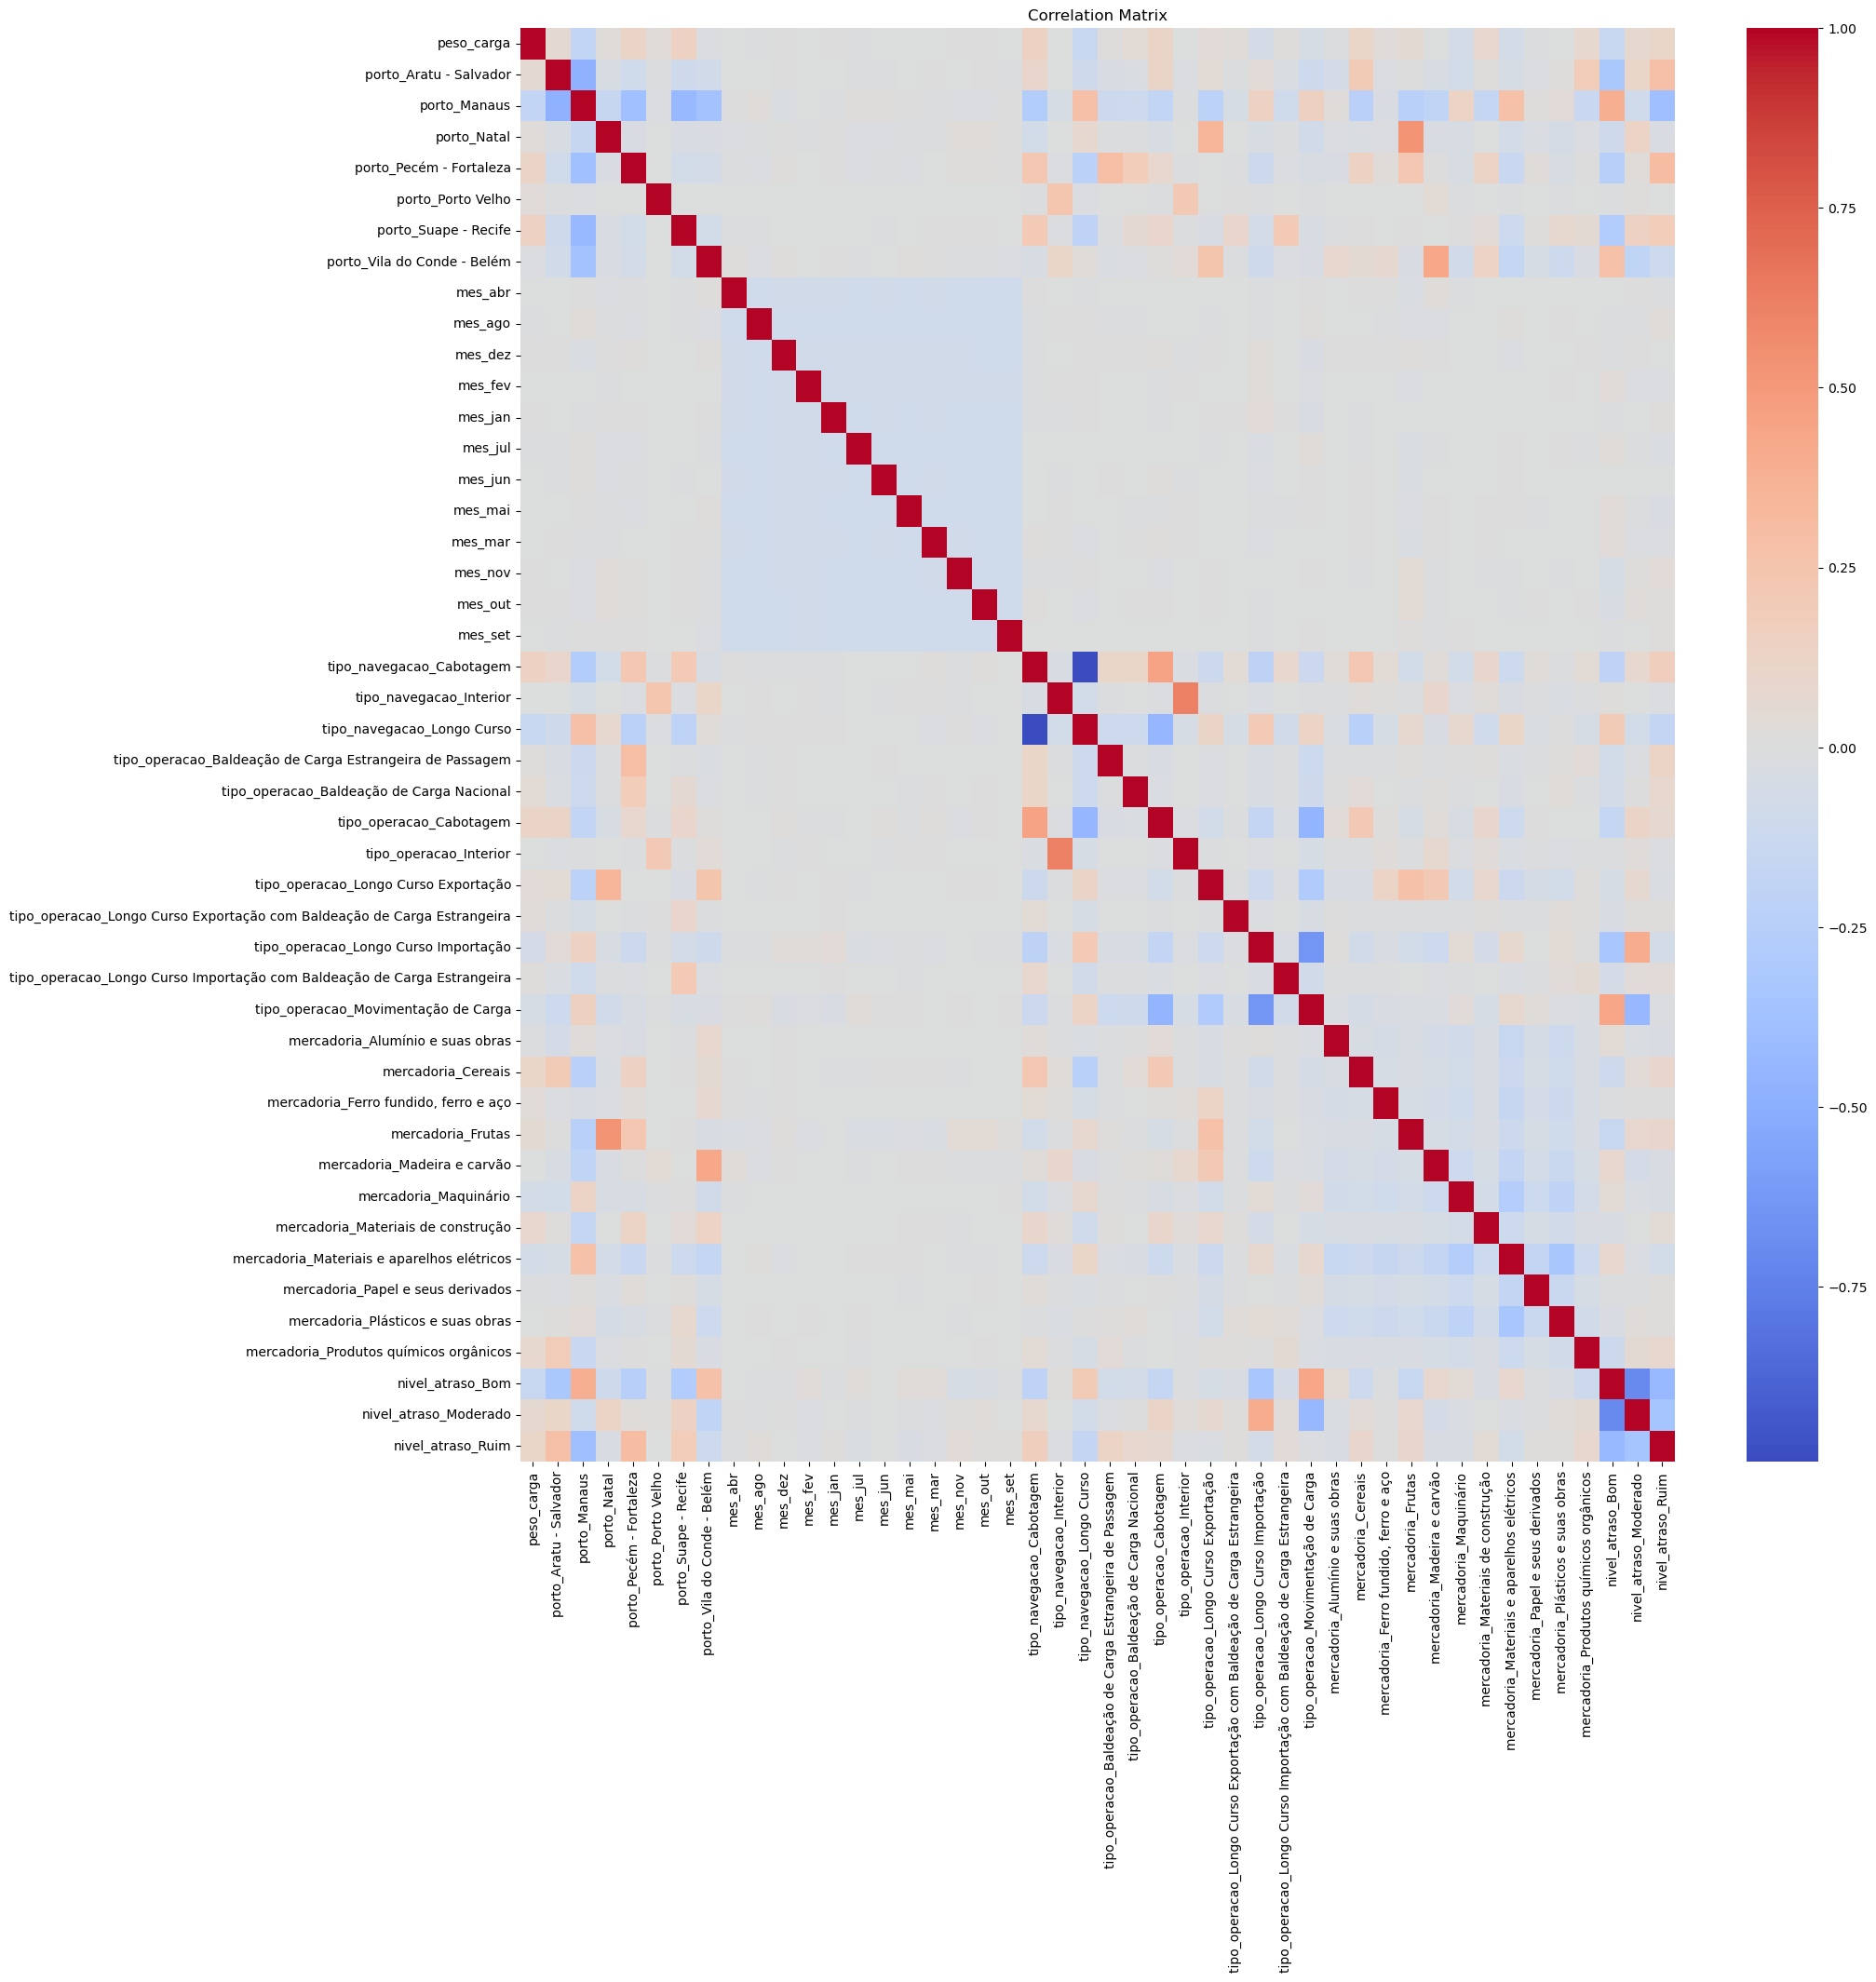

In [3]:
# Selecionar colunas com variaveis categoricas
categorical_cols = [cname for cname in df_sample.columns if
                    df_sample[cname].nunique() < 20 and 
                    df_sample[cname].dtype == "object"]

# Selecionar colunas numericas
numerical_cols = [cname for cname in df_sample.columns if 
                df_sample[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols

df_sample = df_sample[my_cols]

# Preprocessamento dos dados categoricos para análise de correlação
df_sample_transformed = pd.get_dummies(df_sample, columns=categorical_cols)

df_corr = df_sample_transformed.corr()

# Plot da matriz de correlação
f, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(df_corr,
            cmap='coolwarm',
            ax=ax)
ax.set_title('Correlation Matrix', fontsize=12)

plt.show()

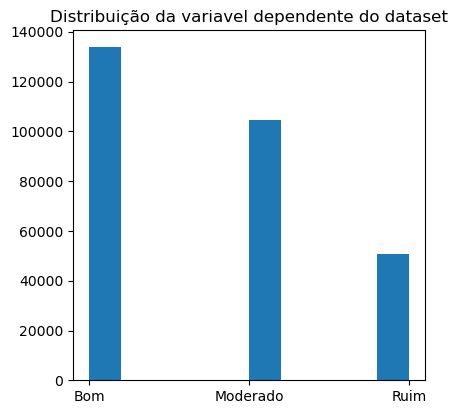

In [4]:
# Separação das variaveis target e explicativas
y = df_sample.nivel_atraso
df_sample.drop('nivel_atraso', axis=1, inplace=True)
y_fact = pd.factorize(y)[0]

y_teste = df_sample_teste.nivel_atraso
df_sample_teste.drop(['nivel_atraso'], axis=1, inplace=True)
y_teste_fac = pd.factorize(y_teste)[0]

# Checando a distribuição de y
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(221)
plt.hist(y, bins = 10)
ax.set_title("Distribuição da variavel dependente do dataset")

plt.show()

In [6]:
# Separando os dados de treino e validação
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_sample, y_fact, 
                                                                train_size=0.75, test_size=0.25,
                                                                random_state=0)

# Selecionado as colunas com variaveis categoricas
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 20 and 
                    X_train_full[cname].dtype == "object"]

# Selecionando as colunas com variaveis quantitativas
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols

# Filtrando os dados de treino pelas colunas
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
df_sample_teste = df_sample_teste[my_cols].copy()

In [7]:
# Preprocessamento para os dados numericos
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', MinMaxScaler())
])

# Preprocessamento para os dados categoricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Juntando os preprocessamentos de ambos os tipos de dados
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [8]:
# Definindo uma função para plotar as matrizes de confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão sem normalização')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Valor Verdadeiro')
    plt.xlabel('Valor Predito')

Matriz de Confusão sem normalização
[[28528  3626  1322]
 [ 3930 17729  4505]
 [ 2333  5196  5166]]
Matriz de Confusão sem normalização
[[33476     0     0]
 [    0 26164     0]
 [    0     0 12695]]
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['peso_carga']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                      

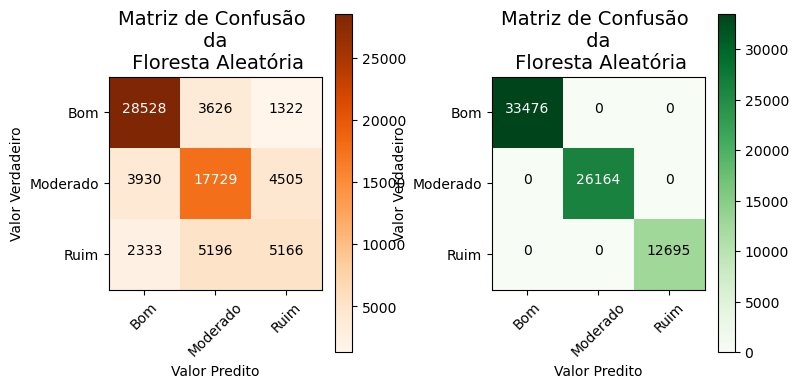

In [9]:
# Define a clean model
model = RandomForestClassifier(random_state = 0)

# Bundle preprocessing and modeling code in a pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])

# Defining Grid params
grid_params = {
    'model__n_estimators': [100, 200, 300, 500, 800, 900, 1000],
    'model__max_features': ['sqrt']
}

# Define the GridSearchCV
grid_search = GridSearchCV(pipe, grid_params, cv=3).fit(X_train, y_train)

rf_model = grid_search.best_estimator_

# Get predictions
rf_class_preds = rf_model.predict(X_valid)
rf_probs_preds = rf_model.predict_proba(X_valid)

# Input the confusions matrix with the results of class preds
rf_cm = confusion_matrix(y_valid, rf_class_preds)
correct_cm = confusion_matrix(y_valid, y_valid)

# Plot the confusion matrix
labels = ['Bom', 'Moderado', 'Ruim']
a = plt.figure(figsize=(8,8))

a.add_subplot(221)
plot_confusion_matrix(rf_cm, labels, title='Matriz de Confusão \n da \n Floresta Aleatória',
                      cmap=plt.cm.Oranges)

a.add_subplot(222)
plot_confusion_matrix(correct_cm, labels, title='Matriz de Confusão \n da \n Floresta Aleatória',
                      cmap=plt.cm.Greens)


# Get the metrics from predict
rf_f1 = f1_score(y_valid, rf_class_preds, average='weighted')
rf_roc = roc_auc_score(y_valid, rf_probs_preds, multi_class='ovr', average='weighted')

print(rf_model)
print('Área debaixo da curva ROC no Random Forest:', rf_roc)
print('F1 Score no Random Forest:', rf_f1)

In [10]:
# Get predictions
rf_class_preds_train = rf_model.predict(X_train)
rf_probs_preds_train = rf_model.predict_proba(X_train)

# Get the metrics from predict
rf_f1 = f1_score(y_train, rf_class_preds_train, average='weighted')
rf_roc = roc_auc_score(y_train, rf_probs_preds_train, multi_class='ovr', average='weighted')
rf_acc = accuracy_score(y_train, rf_class_preds_train)


print('Área debaixo da curva ROC no Random Forest:', rf_roc)
print('F1 Score no Random Forest:', rf_f1)
print('Accuracy rf model:', rf_acc)

Área debaixo da curva ROC no Random Forest: 0.9849457926227942
F1 Score no Random Forest: 0.922875699490869
Accuracy rf model: 0.9233931171775636


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['peso_carga']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                       

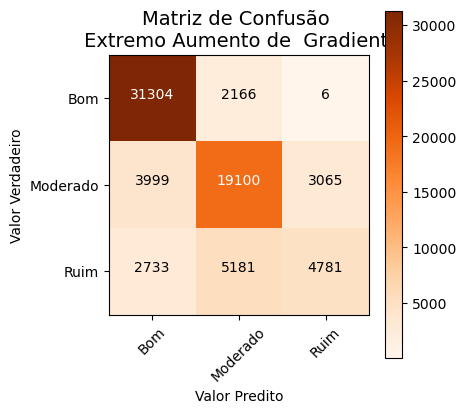

In [11]:
# XGB model 
model_1 = XGBClassifier(verbosity=0)

# Bundle preprocessing and modeling code in a pipeline
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model_1', model_1)])

# Defining Grid params
grid_params_xgb = {'model_1__n_estimators': [900, 950, 1000],
                   'model_1__learning_rate': [0.001, 0.01, 0.1],
                   'model_1__max_depth': [7, 8, 9]}

# Define the GridSearchCV
grid_search_xgb = GridSearchCV(pipe_xgb, grid_params_xgb, cv=3).fit(X_train, y_train)

xgb_model = grid_search_xgb.best_estimator_

print(xgb_model)

# Preprocessing of validation data, get predictions
xgb_class_preds = xgb_model.predict(X_valid)
xgb_probs_preds = xgb_model.predict_proba(X_valid)

# Input the confusions matrix with the results of class preds
xgb_cm = confusion_matrix(y_valid, xgb_class_preds)

# Generates a 100% accuracy matrix
correct_cm = confusion_matrix(y_valid, y_valid)

# Plot the confusion matrix
labels = ['Bom', 'Moderado', 'Ruim']
a = plt.figure(figsize=(8,8))

a.add_subplot(221)
plot_confusion_matrix(xgb_cm, labels, title='Matriz de Confusão \n Extremo Aumento de  Gradiente',
                      cmap=plt.cm.Oranges)


# Get the metrics from predict
xgb_f1 = f1_score(y_valid, xgb_class_preds, average='weighted')
xgb_roc = roc_auc_score(y_valid, xgb_probs_preds, multi_class='ovr', average='weighted')

print('Área debaixo da curva ROC no XGBoosting:', xgb_roc)
print('F1 Score no XGBoosting:', xgb_f1)

In [12]:
# Preprocessing of validation data, get predictions
xgb_class_preds_train = xgb_model.predict(X_train)
xgb_probs_preds_train = xgb_model.predict_proba(X_train)

# Get the metrics from predict
xgb_f1 = f1_score(y_train, xgb_class_preds_train, average='weighted')
xgb_roc = roc_auc_score(y_train, xgb_probs_preds_train, multi_class='ovr', average='weighted')
xgb_acc = accuracy_score(y_train, xgb_class_preds_train)

print('Área debaixo da curva ROC no XGBoosting:', xgb_roc)
print('F1 Score no XGBoosting:', xgb_f1)
print('Accuracy xgb model:', xgb_acc)

Área debaixo da curva ROC no XGBoosting: 0.9125074279133099
F1 Score no XGBoosting: 0.7614457268879656
Accuracy xgb model: 0.7737368896425872


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['peso_carga']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                       

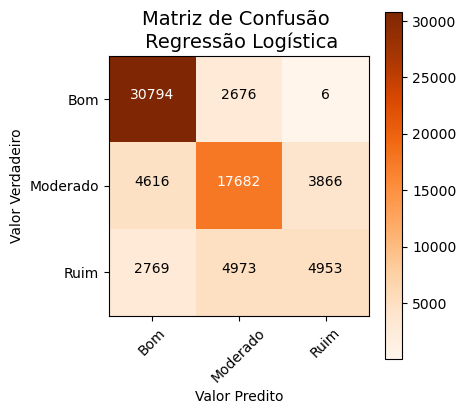

In [13]:
# LogReg model 
model_2 = LogisticRegression()

# Bundle preprocessing and modeling code in a pipeline
pipe_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model_2', model_2)])

# Defining Grid params
grid_params_logreg = {'model_2__penalty': ['l2', 'None'],
                      'model_2__C': [0.5, 1, 3, 7],
                      'model_2__multi_class': ['multinomial']}

# Define the GridSearchCV
grid_search_logreg = GridSearchCV(pipe_logreg, grid_params_logreg, cv=3).fit(X_train, y_train)

logreg_model = grid_search_logreg.best_estimator_

print(logreg_model)

# Preprocessing of validation data, get predictions
logreg_class_preds = logreg_model.predict(X_valid)
logreg_probs_preds = logreg_model.predict_proba(X_valid)

# Input the confusions matrix with the results of class preds
logreg_cm = confusion_matrix(y_valid, logreg_class_preds)

# Generates a 100% accuracy matrix
correct_cm = confusion_matrix(y_valid, y_valid)

# Plot the confusion matrix
labels = ['Bom', 'Moderado', 'Ruim']
a = plt.figure(figsize=(8,8))

a.add_subplot(222)
plot_confusion_matrix(logreg_cm, labels, title='Matriz de Confusão \n Regressão Logística',
                      cmap=plt.cm.Oranges)


# Get the metrics from predict
logreg_f1 = f1_score(y_valid, logreg_class_preds, average='weighted')
logreg_roc = roc_auc_score(y_valid, logreg_probs_preds, multi_class='ovr', average='weighted')

print('Área debaixo da curva ROC na Regressão Logística:', logreg_roc)
print('F1 Score na Regressão Logística:', logreg_f1)

In [14]:
# Predições de treino
logreg_class_preds_train = logreg_model.predict(X_train)
logreg_probs_preds_train = logreg_model.predict_proba(X_train)

# Métricas da predição
logreg_f1 = f1_score(y_train, logreg_class_preds_train, average='weighted')
logreg_roc = roc_auc_score(y_train, logreg_probs_preds_train, multi_class='ovr', average='weighted')
logreg_acc = accuracy_score(y_train, logreg_class_preds_train)

print('Área debaixo da curva ROC no XGBoosting:', logreg_roc)
print('F1 Score no XGBoosting:', logreg_f1)
print('Accuracy xgb model:', logreg_acc)

Área debaixo da curva ROC no XGBoosting: 0.876884364917889
F1 Score no XGBoosting: 0.7281619091201651
Accuracy xgb model: 0.7396453521594072


In [16]:
y_train_nn = np.asarray(y_train).astype(np.float64)
y_valid_nn = np.asarray(y_valid).astype(np.float64)

y_train_nn = tf.convert_to_tensor(y_train_nn, dtype=tf.int64)
y_valid_nn = tf.convert_to_tensor(y_valid_nn, dtype=tf.int64)

X_train_nn = X_train.copy()
X_valid_nn = X_valid.copy()

X_train_nn['peso_carga'] = np.asarray(X_train['peso_carga']).astype(np.float64)
X_valid_nn['peso_carga'] = np.asarray(X_valid['peso_carga']).astype(np.float64)

X_train_nn['peso_carga'] = tf.convert_to_tensor(X_train['peso_carga'], dtype=tf.float64)
X_valid_nn['peso_carga'] = tf.convert_to_tensor(X_valid['peso_carga'], dtype=tf.float64)

X_train_nn = pd.get_dummies(X_train_nn, columns=categorical_cols)
X_valid_nn = pd.get_dummies(X_valid_nn, columns=categorical_cols)

Epoch 264: early stopping
Matriz de Confusão sem normalização
[[31234  2240     2]
 [ 3929 20272  1963]
 [ 2731  6448  3516]]
Matriz de Confusão sem normalização
[[33476     0     0]
 [    0 26164     0]
 [    0     0 12695]]
Área debaixo da curva ROC na Rede Neural: 0.9039701392036275
F1 Score na Rede Neural: 0.7390030069138557


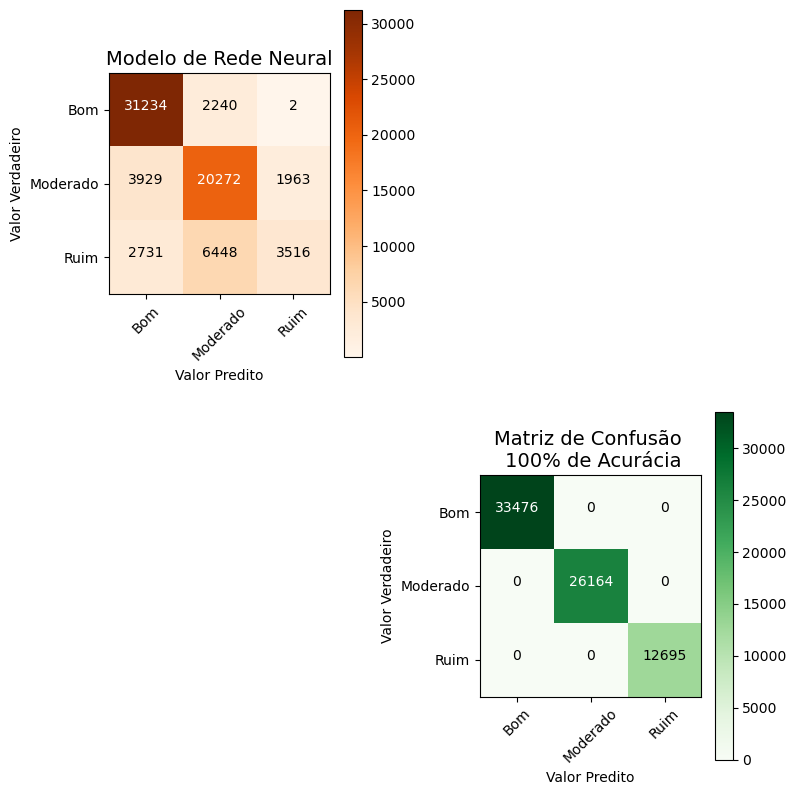

In [17]:
# Modelo de rede neural
n_inputs = X_train_nn.shape[1]

# Early stopping method to avoid overfit
callback = EarlyStopping(monitor = 'val_loss', patience=200, verbose=1, min_delta=0)

# Criação do modelo
nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compilação do modelo tunando com método Adam
nn_model.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treino do modelo
nn_model.fit(X_train_nn, y_train_nn, validation_split=0.2, batch_size=100, epochs=1000, shuffle=True, verbose=0,
             callbacks=[callback])

# Fazer predições no x de teste e tornar em classes com o np
nn_predictions = nn_model.predict(X_valid_nn, batch_size=200, verbose=0)
nn_class_predictions = np.argmax(nn_predictions, axis=1)

# Alimentar a matriz de confusão com os resultados da predição
nn_cm = confusion_matrix(y_valid_nn, nn_class_predictions)
correct_cm_nn = confusion_matrix(y_valid_nn, y_valid_nn)

# Matriz de confusão
labels = ['Bom', 'Moderado', 'Ruim']
a = plt.figure(figsize=(8,8))

a.add_subplot(221)
plot_confusion_matrix(nn_cm, labels, title='Modelo de Rede Neural',
                      cmap=plt.cm.Oranges)

a.add_subplot(224)
plot_confusion_matrix(correct_cm_nn, labels, title='Matriz de Confusão \n 100% de Acurácia',
                     cmap=plt.cm.Greens)

# Métricas da predição de rede neural
nn_f1 = f1_score(y_valid_nn, nn_class_predictions, average='weighted')
nn_roc = roc_auc_score(y_valid_nn, nn_predictions, multi_class='ovr', average='weighted')

print('Área debaixo da curva ROC na Rede Neural:', nn_roc)
print('F1 Score na Rede Neural:', nn_f1)

In [18]:
nn_acc = accuracy_score(y_valid_nn, nn_class_predictions)
rf_acc = accuracy_score(y_valid, rf_class_preds)
logreg_acc = accuracy_score(y_valid, logreg_class_preds)
xgb_acc = accuracy_score(y_valid, xgb_class_preds)

print('Accuracy nn model:', nn_acc)
print('Accuracy logreg model:', logreg_acc)
print('Accuracy rf model:', rf_acc)
print('Accuracy xgb model:', xgb_acc)

Accuracy nn model: 0.7606552844404507
Accuracy logreg model: 0.7386327503974562
Accuracy rf model: 0.7109006704914633
Accuracy xgb model: 0.7629086887398908


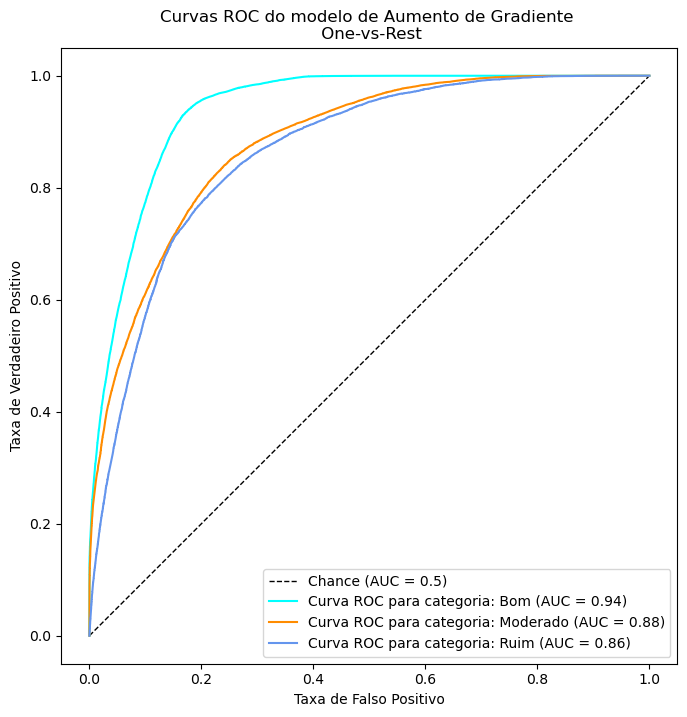

Área debaixo da curva ROC no XGBoosting: 0.8948568294621189
F1 Score no XGBoosting: 0.6850452911391472
Accuracy xgb model: 0.7456279809220986
precision: 0.722244406103596
recall: 0.6704767111704673


In [19]:
y = label_binarize(y_fact, classes=[0,1,2])

n_classes = 3

# Embaralha e divide training e test sets
X_tr, X_tes, y_tr, y_tes = train_test_split(df_sample, y, train_size=0.75, test_size=0.25, random_state=0)

X_tr = X_tr[my_cols].copy()
X_tes = X_tes[my_cols].copy()

# classifier
clf = OneVsRestClassifier(XGBClassifier(verbosity=0, n_estimators = 950, random_state=0, learning_rate=0.01, max_depth=8))

# Pipeline de preprocessamento e modelo
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('clf', clf)])

modelo_xgb = pipe.fit(X_tr, y_tr)

y_score = modelo_xgb.predict(X_tes)
y_score_probs = modelo_xgb.predict_proba(X_tes)

# Plotando a Curva ROC
from itertools import cycle

fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(
    (0,1),
    (0,1),
    label="Chance (AUC = 0.5)",
    color="black",
    linestyle="--",
    linewidth=1,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_tes[:, class_id],
        y_score_probs[:, class_id],
        name=f"Curva ROC para categoria: {target_names[class_id]}",
        color=color,
        ax=ax,
        #plot_chance_level=(class_id == 2)
    )
plt.axis("square")
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curvas ROC do modelo de Aumento de Gradiente \n One-vs-Rest")
plt.legend()
plt.show()

# Métricas da predição
xgb_f1 = f1_score(y_tes, y_score, average='macro')
xgb_roc = roc_auc_score(y_tes, y_score_probs, multi_class='ovr', average='macro')
xgb_acc = accuracy_score(y_tes, y_score)
xgb_precision = precision_score(y_tes, y_score, average='macro')
xgb_recall = recall_score(y_tes,y_score, average='macro')

print('Área debaixo da curva ROC no XGBoosting:', xgb_roc)
print('F1 Score no XGBoosting:', xgb_f1)
print('Accuracy xgb model:', xgb_acc)
print('precision:', xgb_precision)
print('recall:', xgb_recall)

In [20]:
y_score_tr = modelo_xgb.predict(X_tr)
y_score_probs_tr = modelo_xgb.predict_proba(X_tr)

# Métricas da predição
xgb_f1_tr = f1_score(y_tr, y_score_tr, average='macro')
xgb_roc_tr = roc_auc_score(y_tr, y_score_probs_tr, multi_class='ovr', average='macro')
xgb_acc_tr = accuracy_score(y_tr, y_score_tr)

print('Área debaixo da curva ROC no XGBoosting:', xgb_roc_tr)
print('F1 Score no XGBoosting:', xgb_f1_tr)
print('Accuracy xgb model:', xgb_acc_tr)

Área debaixo da curva ROC no XGBoosting: 0.9020745885889978
F1 Score no XGBoosting: 0.7000071793135924
Accuracy xgb model: 0.7553501317948056
